In [1]:
!pip install gym torch numpy matplotlib

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100: Total Reward: 16.0
Episode 200: Total Reward: 71.0
Episode 300: Total Reward: 162.0
Episode 400: Total Reward: 386.0
Episode 500: Total Reward: 500.0
Episode 600: Total Reward: 500.0
Episode 700: Total Reward: 201.0
Episode 800: Total Reward: 500.0
Episode 900: Total Reward: 500.0
Episode 1000: Total Reward: 500.0
Episode 1100: Total Reward: 500.0
Episode 1200: Total Reward: 500.0
Episode 1300: Total Reward: 500.0
Episode 1400: Total Reward: 363.0
Episode 1500: Total Reward: 199.0
Episode 1600: Total Reward: 500.0
Episode 1700: Total Reward: 500.0
Episode 1800: Total Reward: 500.0
Episode 1900: Total Reward: 500.0
Episode 2000: Total Reward: 500.0
Episode 2100: Total Reward: 500.0
Episode 2200: Total Reward: 500.0
Episode 2300: Total Reward: 500.0
Episode 2400: Total Reward: 500.0
Episode 2500: Total Reward: 500.0
Episode 2600: Total Reward: 500.0
Episode 2700: Total Reward: 500.0
Episode 2800: Total Reward: 500.0
Episode 2900: Total Reward: 421.0
Episode 3000: Total Rewar

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


GIF saved at cart_pole_result1.gif


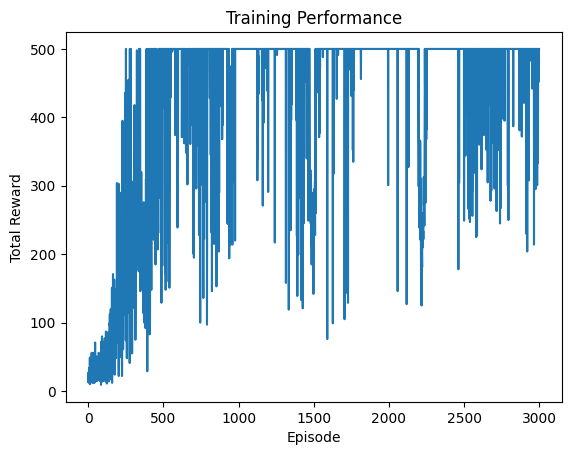

In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from PIL import Image

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

def train_policy_gradient(env, policy, optimizer, num_episodes=3000, gamma=0.99):
    episode_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        log_probs = []
        rewards = []
        done = False

        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action_probs = policy(state)
            action = torch.multinomial(action_probs, 1).item()
            log_prob = torch.log(action_probs[action])

            next_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)

            state = next_state

        # Calculate discounted rewards and normalize them
        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(rewards):
            cumulative_reward = r + gamma * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)

        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)
        baseline = discounted_rewards.mean()  # Adding a baseline
        discounted_rewards = (discounted_rewards - baseline) / (discounted_rewards.std() + 1e-9)

        policy_loss = []
        for log_prob, reward in zip(log_probs, discounted_rewards):
            policy_loss.append(-log_prob * reward)

        optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        optimizer.step()

        episode_rewards.append(sum(rewards))

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}: Total Reward: {sum(rewards)}")

    return episode_rewards

# Function to create a GIF of the trained agent
def create_gif(env, policy, gif_path='cart_pole_result1.gif', duration=100):
    frames = []
    state = env.reset()
    done = False

    for _ in range(1000):  # Increase this to capture more frames for a longer GIF
        frame = env.render(mode='rgb_array')
        frames.append(Image.fromarray(frame))

        state = torch.tensor(state, dtype=torch.float32)
        action_probs = policy(state)
        action = torch.multinomial(action_probs, 1).item()
        state, _, done, _ = env.step(action)

        if done:
            break

    # Save as GIF
    frames[0].save(gif_path, save_all=True, append_images=frames[1:], loop=0, duration=duration)
    env.close()
    print(f"GIF saved at {gif_path}")

# Main code to train the model and create the GIF
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

policy = PolicyNetwork(input_dim, output_dim)
optimizer = optim.Adam(policy.parameters(), lr=0.001)  # Reduce learning rate for more stable training

# Train the policy
episode_rewards = train_policy_gradient(env, policy, optimizer)

# Create a GIF of the trained agent
create_gif(env, policy, duration=100)  # Increase duration for a slower GIF

# Plot the episode rewards
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.show()


In [4]:
def test_policy(env, policy, num_test_episodes=100):
    test_rewards = []
    for episode in range(num_test_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():  # Disable gradient computation for inference
                action_probs = policy(state)
            action = torch.multinomial(action_probs, 1).item()
            state, reward, done, _ = env.step(action)
            total_reward += reward

        test_rewards.append(total_reward)
        print(f"Test Episode {episode + 1}: Total Reward: {total_reward}")

    average_reward = np.mean(test_rewards)
    print(f"\nAverage Reward over {num_test_episodes} test episodes: {average_reward}")

    return test_rewards

# Run the test model
test_rewards = test_policy(env, policy)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test Episode 1: Total Reward: 327.0
Test Episode 2: Total Reward: 500.0
Test Episode 3: Total Reward: 500.0
Test Episode 4: Total Reward: 500.0
Test Episode 5: Total Reward: 500.0
Test Episode 6: Total Reward: 500.0
Test Episode 7: Total Reward: 500.0
Test Episode 8: Total Reward: 500.0
Test Episode 9: Total Reward: 500.0
Test Episode 10: Total Reward: 500.0
Test Episode 11: Total Reward: 500.0
Test Episode 12: Total Reward: 500.0
Test Episode 13: Total Reward: 500.0
Test Episode 14: Total Reward: 500.0
Test Episode 15: Total Reward: 500.0
Test Episode 16: Total Reward: 482.0
Test Episode 17: Total Reward: 500.0
Test Episode 18: Total Reward: 500.0
Test Episode 19: Total Reward: 500.0
Test Episode 20: Total Reward: 500.0
Test Episode 21: Total Reward: 500.0
Test Episode 22: Total Reward: 500.0
Test Episode 23: Total Reward: 500.0
Test Episode 24: Total Reward: 500.0
Test Episode 25: Total Reward: 500.0
Test Episode 26: Total Reward: 500.0
Test Episode 27: Total Reward: 500.0
Test Episo